# CPI ARIMA model

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
cpi = pd.read_csv('CPI_Data/Monthly_cpi_index.csv', index_col = 0)

#set index to datetime
cpi.index = pd.to_datetime(cpi.index, infer_datetime_format = True)
cpi

,Food,Food at home,Cereals and bakery products,Cereals and cereal products,Flour and prepared flour mixes,Breakfast cereal,"Rice, pasta, cornmeal",Bakery products,Bread,"Fresh biscuits, rolls, muffins",...,Transportation,Private transportation,New and used motor vehicles,Utilities and public transportation,Household furnishings and operations,Other goods and services,Personal care,Recorded music and music subscriptions,"Men's underwear, nightwear, swimwear, and accessories",All items
2012-01-01,232.666,231.694,266.677,234.159,252.159,228.664,242.992,283.880,170.658,167.911,...,210.799,206.307,99.659,205.521,125.629,391.382,210.299,89.691,148.547,227.842
2012-02-01,232.486,231.180,267.821,233.362,250.564,227.984,242.217,286.484,172.978,168.364,...,214.429,210.013,99.889,205.398,126.180,391.236,210.330,89.896,148.183,228.329
2012-03-01,232.792,231.383,267.101,232.660,252.104,227.997,238.975,285.771,172.955,168.406,...,220.842,216.536,100.325,205.637,126.107,392.364,211.289,89.704,149.106,228.807
2012-04-01,233.234,231.711,268.014,233.662,252.102,228.862,240.693,286.589,173.559,166.211,...,223.083,218.563,100.977,206.050,126.114,393.320,211.865,89.084,150.584,229.187
2012-05-01,233.339,231.518,268.653,235.054,254.336,230.326,241.615,286.629,173.581,167.158,...,220.768,215.978,101.399,206.866,125.905,392.859,211.649,88.904,155.044,228.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,279.135,259.825,288.990,236.194,248.823,229.855,245.495,319.545,192.971,186.280,...,238.333,237.994,119.475,229.805,132.076,479.048,244.968,79.549,167.846,273.092
2021-09-01,281.506,262.695,292.069,236.183,250.198,229.122,245.890,324.458,196.492,194.852,...,236.373,236.655,117.947,229.568,133.462,479.525,244.840,79.820,168.872,274.214
2021-10-01,284.205,265.478,294.625,239.371,249.956,236.615,245.062,326.628,198.052,195.203,...,241.042,241.413,120.192,231.301,134.745,483.592,246.307,79.954,170.986,276.590
2021-11-01,285.507,266.384,295.909,241.091,246.663,238.343,248.552,327.648,200.415,197.481,...,245.532,245.735,122.436,231.880,135.345,484.683,246.445,79.385,170.751,278.524


In [3]:
#there are some null values that we can't solve so will drop those categories
cpi = cpi.dropna(axis = 1)

In [4]:
cpi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Columns: 305 entries, Food to All items
dtypes: float64(305)
memory usage: 286.9 KB


## Stationarity Check

Before running an ARIMA model, we must check for stationarity. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

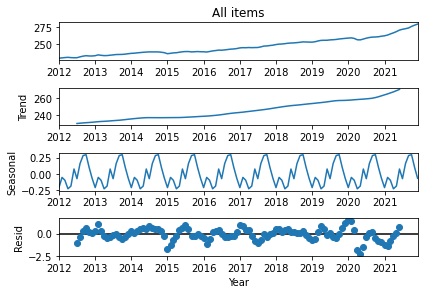

In [5]:
# need to use statmodels decomposition
# decomposition is used to separate the data into potential seasonality, trend, and random residual

decomp = sm.tsa.seasonal_decompose(cpi["All items"], model = 'additive')
fig = decomp.plot()
plt.xlabel('Year')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

From looking at the core stationarity graphs, we do notice that there is prominent seasonality where there are consistent trends for it throughout the years. Along with that, residuals, which show how affected the data is, is easily affected where there is high variability among the data. The trend shows a linear trend that is representative of how our economy is where inflation exists and prices do essentially go up.

This resource helped to understand what was going on: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

## Dicky-Fuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
# function that tests stationarity with Dicky Fuller
def dicky_stationarity_test(data):
    moving_average = data.rolling(window = 12).mean()
    moving_std = data.rolling(window = 12).std()
    original_plot = plt.plot(data, label = 'original', color = 'black')
    mean_plot = plt.plot(moving_average, label = 'mean', color = 'blue')
    std_plot = plt.plot(moving_std, label = 'std', color = 'red')
    
    plt.legend(loc='best')
    plt.title('Rolling Average and Standard Deviation')
    plt.show(block = False)
    
    print('Dicky-Fuller Test results:')
    dftest = adfuller(data, autolag='AIC') #default autolag
    output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)

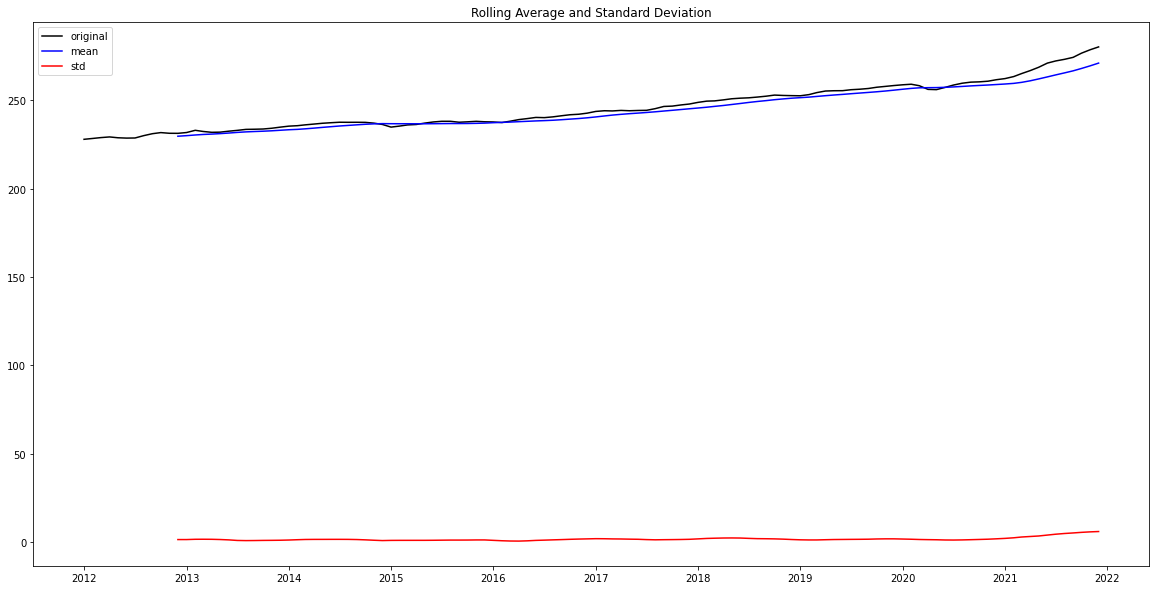

Dicky-Fuller Test results:
Test Statistic                   3.207398
p-value                          1.000000
Number of Lags Used              2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [8]:
dicky_stationarity_test(cpi['All items'])

In [9]:
# Augmented Dicky-Fuller test, gives p value  
dftest = adfuller(cpi['All items'], autolag='AIC') #default autolag
output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

Test Statistic                   3.207398
p-value                          1.000000
Number of Lags Used              2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


Since the test statistic is greater than the critical value (5%), this means that we fail to reject the null so the data is not stationary. This doesn't mean that we can't still run the model so we will continue.

## Data preparation

There are three important parameters that need to be found in order for our model to be created.

- p, parameter associated with the **Auto-Regressive** part
- d, parameter for **Integration** part of model
- q, parameter for **Moving Average** part of model

But first, we have to fix the stationarity problem since it is not stationary before finding any parameters. This can be achieved by differencing. Differencing is used to remove the non-stationarity caused by the trend. The number of times that we have to do differencing is the parameter for d.

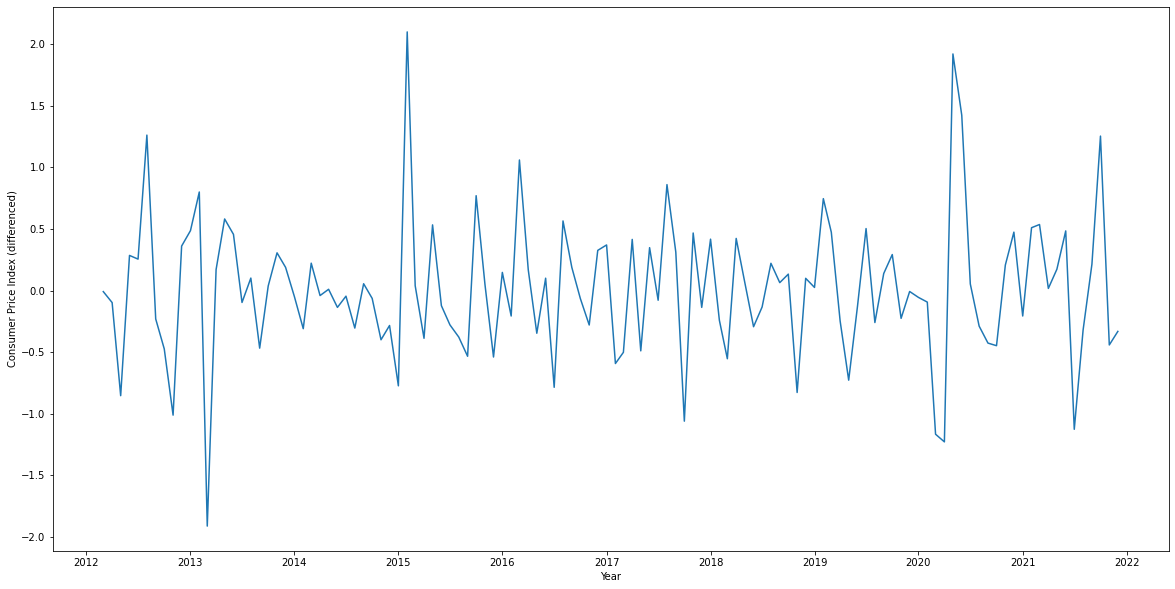

In [10]:
# Differencing - remove non-stationarity.
plt.figure(figsize=(20, 10))

#doing difference twice here, this removes any stationary
cpi_diff = (((cpi.diff()).dropna()).diff()).dropna()

plt.xlabel('Year')
plt.ylabel('Consumer Price Index (differenced)')
plt.plot(cpi_diff['All items'])

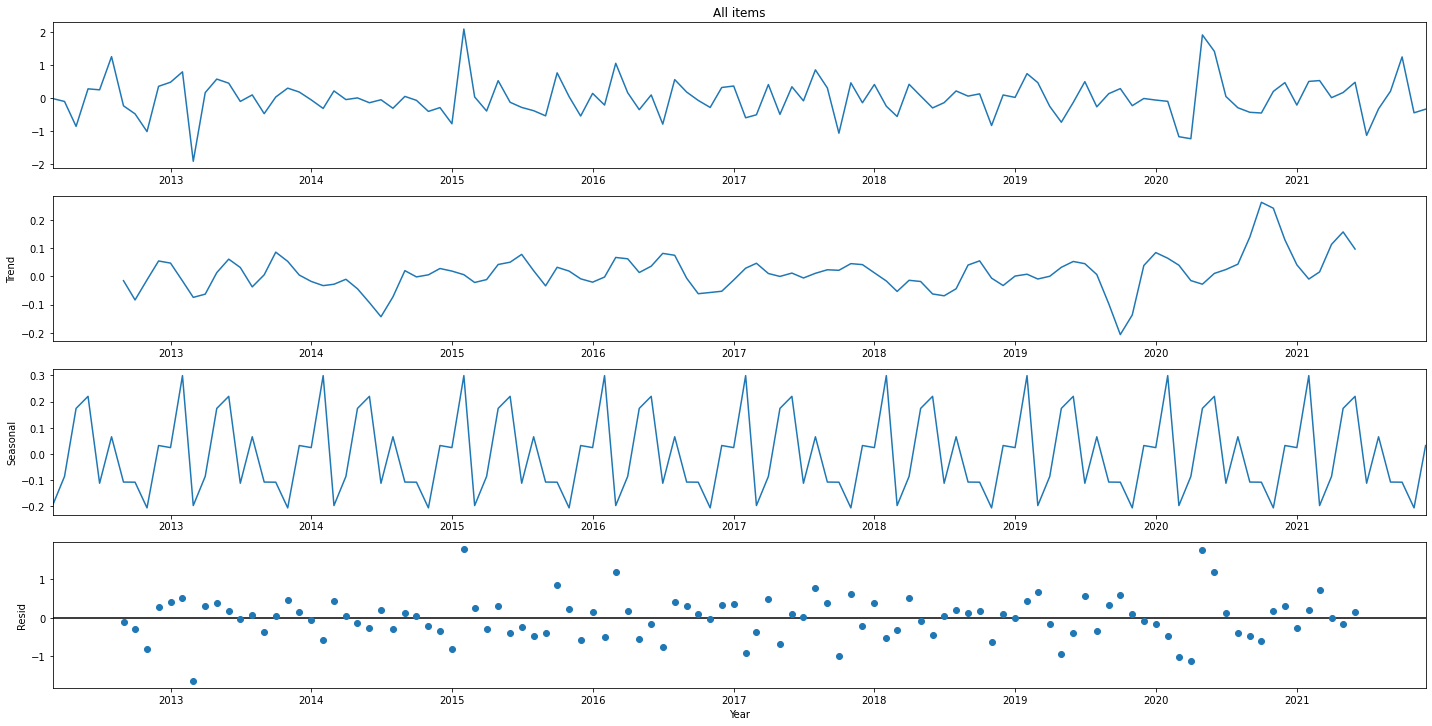

In [11]:
#running decomp again to see the changes to stationarity
decomp = sm.tsa.seasonal_decompose(cpi_diff['All items'], model = 'additive')
fig = decomp.plot()
plt.xlabel('Year')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

The seasonal decomposition shows that there is no apparent trend anymore, the seasonality is still present, but the residuals are random now.

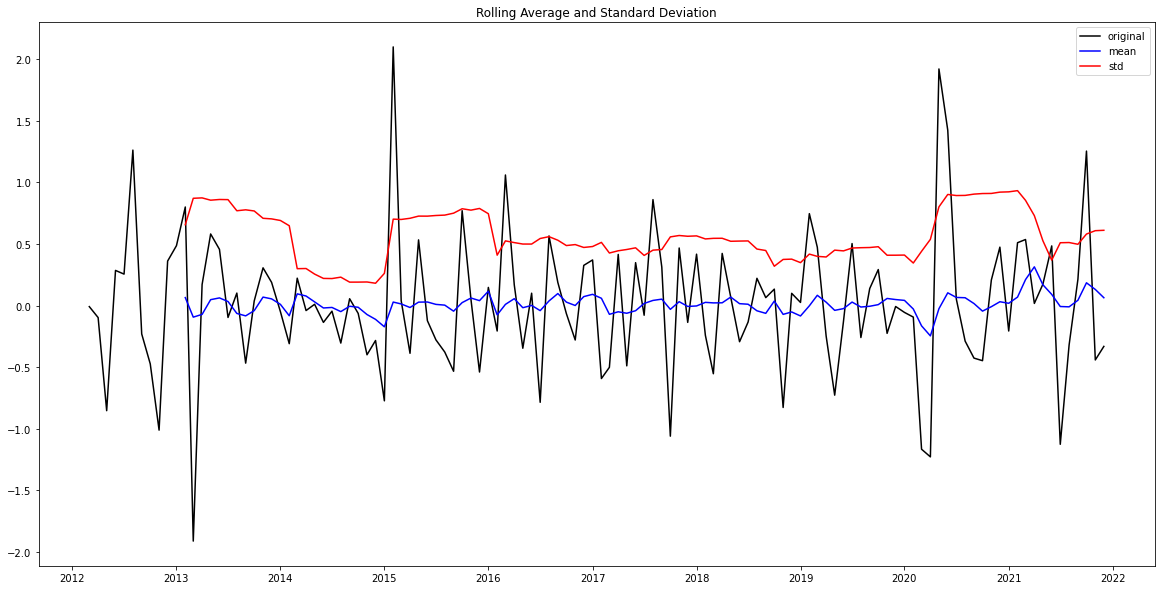

Dicky-Fuller Test results:
Test Statistic                -6.949330e+00
p-value                        9.784625e-10
Number of Lags Used            5.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


In [12]:
#run a dicky-fuller test again on new differenced data
dicky_stationarity_test(cpi_diff['All items'])

After running Dicky-Fuller again, we can see that our test statistic is lower than our 5% critical value which means that we can reject the null and support the alternative. This means that we can assume our data is stationary now.

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

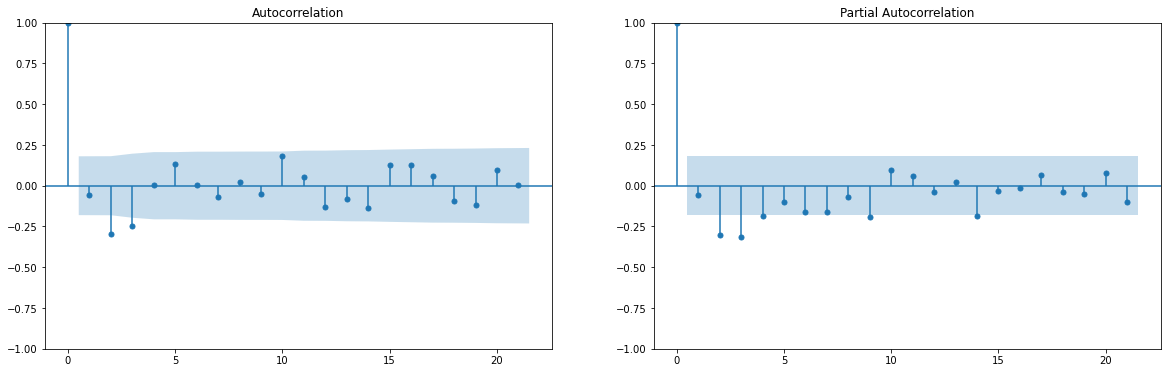

In [14]:
# Visualize the ACF (auto correlation function) and PACF (partial autocorrelation function)plots to 
# find parameters p and q, but on the differenced data since we need data to be stationary.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(cpi_diff['All items'], ax = ax1)
plot_pacf(cpi_diff['All items'], ax = ax2, method='ywmle')
plt.show()

In [15]:
# split the data in train and testing data samples
train = cpi.iloc[:96]
test = cpi.iloc[96::]

In [16]:
# need to import auto-arima which lets us do grid search for ARIMA model
from pmdarima.arima import auto_arima

In ARIMA models, must give the p,d,q values to the model, but using Auto ARIMA, it generates the best parameters for itself.

In [17]:
# do a grid search for our ARIMA model
grid_search = auto_arima(train['All items'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=2, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(grid_search.aic())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=150.669, Time=1.52 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=150.014, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=148.669, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.776 seconds
148.66892613701876


## ARIMA model training

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
# fit the ARIMA model using the ARIMA package from statmodels, from parameters found using auto ARIMA
X = train['All items']
X.index = pd.DatetimeIndex(X.index.values, freq=X.index.inferred_freq) #inferred_freq: infer most likely frequency
model = ARIMA(X, order=(0, 2, 0))
model_fit = model.fit()

In [20]:
# look at summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              All items   No. Observations:                   96
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 -73.334
Date:                Mon, 07 Mar 2022   AIC                            148.669
Time:                        22:41:58   BIC                            151.212
Sample:                    01-01-2012   HQIC                           149.696
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2787      0.026     10.883      0.000       0.229       0.329
===================================================================================
Ljung-Box (L1) (Q):                   2.73   Jarque-Bera (JB):                36.84
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.20
Prob(H) (two-sided):                  0.16   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

CRITIQUE THE MODEL AND ANALYZE NUMBERS!!!

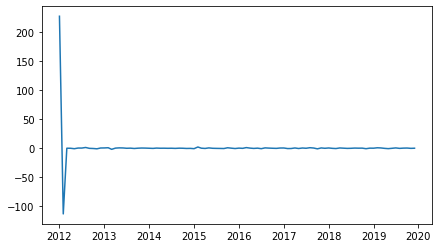

In [21]:
# plot residuals to see how it is affected
plt.figure(figsize=(7, 4))
plt.plot(model_fit.resid)

## Prediction with ARIMA model

In [22]:
train

,Food,Food at home,Cereals and bakery products,Cereals and cereal products,Flour and prepared flour mixes,Breakfast cereal,"Rice, pasta, cornmeal",Bakery products,Bread,"Fresh biscuits, rolls, muffins",...,Transportation,Private transportation,New and used motor vehicles,Utilities and public transportation,Household furnishings and operations,Other goods and services,Personal care,Recorded music and music subscriptions,"Men's underwear, nightwear, swimwear, and accessories",All items
2012-01-01,232.666,231.694,266.677,234.159,252.159,228.664,242.992,283.880,170.658,167.911,...,210.799,206.307,99.659,205.521,125.629,391.382,210.299,89.691,148.547,227.842
2012-02-01,232.486,231.180,267.821,233.362,250.564,227.984,242.217,286.484,172.978,168.364,...,214.429,210.013,99.889,205.398,126.180,391.236,210.330,89.896,148.183,228.329
2012-03-01,232.792,231.383,267.101,232.660,252.104,227.997,238.975,285.771,172.955,168.406,...,220.842,216.536,100.325,205.637,126.107,392.364,211.289,89.704,149.106,228.807
2012-04-01,233.234,231.711,268.014,233.662,252.102,228.862,240.693,286.589,173.559,166.211,...,223.083,218.563,100.977,206.050,126.114,393.320,211.865,89.084,150.584,229.187
2012-05-01,233.339,231.518,268.653,235.054,254.336,230.326,241.615,286.629,173.581,167.158,...,220.768,215.978,101.399,206.866,125.905,392.859,211.649,88.904,155.044,228.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,258.410,241.153,276.619,228.385,239.327,220.688,240.329,304.417,182.235,178.077,...,211.084,206.979,100.407,218.690,123.818,453.074,234.749,82.332,157.029,256.179
2019-09-01,258.943,241.543,277.308,226.997,238.686,220.068,237.621,306.410,185.084,179.626,...,209.350,205.068,98.751,218.639,124.183,453.193,234.603,79.378,161.218,256.596
2019-10-01,259.632,242.340,276.470,226.009,232.780,220.408,236.496,305.674,185.162,180.528,...,210.487,206.070,98.684,218.527,124.256,455.225,235.578,80.003,159.172,257.305
2019-11-01,259.467,241.726,276.166,224.887,224.422,218.774,238.499,305.890,187.598,180.255,...,209.763,205.317,98.441,218.568,123.733,456.262,235.797,80.586,155.353,257.788


In [23]:
model_fit.forecast(8, alpha = .05)

2020-01-01    258.738
2020-02-01    259.213
2020-03-01    259.688
2020-04-01    260.163
2020-05-01    260.638
2020-06-01    261.113
2020-07-01    261.588
2020-08-01    262.063
Freq: MS, Name: predicted_mean, dtype: float64

In [24]:
cpi.loc['2020-01-01':].index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

2020-01-01    258.738
2020-02-01    259.213
2020-03-01    259.688
2020-04-01    260.163
2020-05-01    260.638
2020-06-01    261.113
2020-07-01    261.588
2020-08-01    262.063
2020-09-01    262.538
2020-10-01    263.013
2020-11-01    263.488
2020-12-01    263.963
2021-01-01    264.438
2021-02-01    264.913
2021-03-01    265.388
2021-04-01    265.863
2021-05-01    266.338
2021-06-01    266.813
2021-07-01    267.288
2021-08-01    267.763
2021-09-01    268.238
2021-10-01    268.713
2021-11-01    269.188
2021-12-01    269.663
Freq: MS, Name: predicted_mean, dtype: float64
All items      mean   mean_se  mean_ci_lower  mean_ci_upper
2020-01-01  258.738  0.527935     257.703267     259.772733


Text(0, 0.5, 'Consumer Price Index')

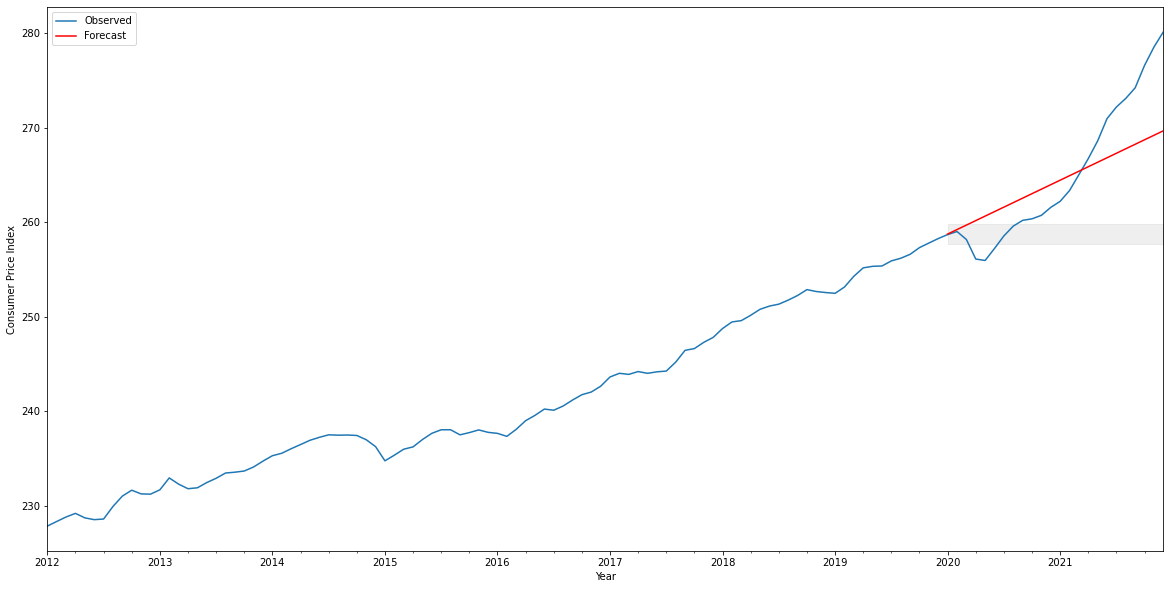

In [25]:
# use the testing data as a means of represent how accurate model is
ax = cpi['All items']['2012-01-01'::].plot(label='Observed')
forecast = model_fit.get_forecast()
forecast_summary = forecast.summary_frame()
forecast_data = model_fit.forecast(24, alpha = .05)
print(forecast_data)

#get the standard error and confidence interval
std_err, conf_int = forecast_summary['mean_se'], [forecast_summary['mean_ci_lower'], forecast_summary['mean_ci_upper']]
forecast = pd.DataFrame(forecast_data).set_index(cpi.loc['2020-01-01':].index)
forecast.plot(ax=ax, style = 'r', label='Forecast')

print(forecast_summary)

# Calculate and visualize the 95% confidence interval.
ax.fill_between(forecast.index, forecast_summary['mean_ci_lower'], forecast_summary['mean_ci_upper'], color='dimgray', alpha=0.1)

# # Add the labels to the plot.
plt.legend(('Observed', 'Forecast'))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')